

## Garbage Classifier: A Machine Learning Approach to Waste Management

#### By Syed Mohammed Ahmed Mehdi

Garbage classification is a crucial task in reducing waste and managing resources effectively, which also plays a critical role in solving the water pollution issue. Our project utilizes **PyTorch** and **ResNet50** to develop a garbage classification model capable of identifying various types of waste.

The model is trained to recognize six categories of garbage, namely **cardboard, glass, metal, paper, plastic**, and **general trash**. By fine-tuning the pre-trained **ResNet50** architecture with a **learning rate** of **0.00005**, we have improved the models accuracy.

The implications of our garbage classification model are significant, particularly in waste management. It can help reduce the amount of waste that ends up on beaches, promote recycling, and conserve natural resources. By classifying waste effectively, we can work towards a cleaner and more sustainable environment, ultimately helping to solve the water pollution issue.



## Importing Libraries

These lines import necessary PyTorch libraries and modules along with some external libraries like Matplotlib (used to create visualizations) and Numpy (used for mathematical operations on arrays and matrices). 

It also imports some modules and classes from torchvision library. Finally, it imports the OS module.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import random_split

import matplotlib.pyplot as plt
import numpy as np
import random
import os


## Loading the Dataset

The below lines define a directory where the data is stored and print out the names of the subdirectories (garbage classes) present in that directory.


In [2]:
directory  = '../garbage_classification/all_classes/'

garbage_classes = os.listdir(directory)
print(garbage_classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']



## Transforming the Dataset 

Transformations can perform various operations such as *resizing, cropping, normalizing, and augmenting* images. These operations help to preprocess the images to make them suitable for the model and prevent overfitting of the model to specific data points.

In [3]:
# Importing Transforms to modify the images

from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

# Resize all images to 224x224 pixels and converting to Tensor

transformations = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

# Load the dataset and apply the transformations

dataset = ImageFolder(directory, transform = transformations)


## Testing the dataset by randomly displaying images and their labels


Label: glass (Class No: 1)


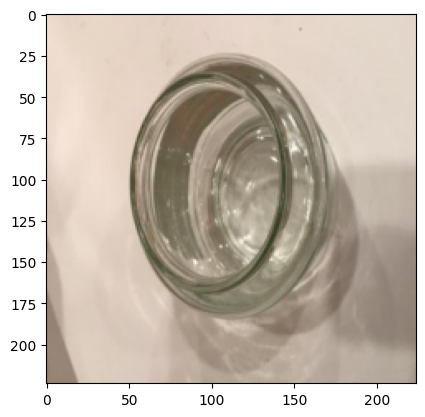

In [4]:
# Permute the dimensions of the image to fit the format of the matplotlib

def display_test(image, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))
    
# Display a random image from the dataset

image, label = dataset[random.randint(0, len(dataset))]
display_test(image, label)




## Setting Random Seed for Reproducibility

The first line sets a random seed value of 43, which is used as the starting point for the random number generator. 

The second line sets the random seed of `PyTorch's` internal random number generator to the value specified by `random_seed`, ensuring that the same sequence of random numbers is generated every time the code is run. This is important for achieving reproducibility in the model training process.


In [5]:
random_seed = 43
torch.manual_seed(random_seed)


## Splitting Dataset & Defining Batch Size

The below cell splits the dataset into three sets - training, validation, and test - using `random_split()` from `PyTorch`. 

The sizes of each set are determined by the proportions 0.6, 0.2, and 0.2 of the dataset length. Then, the data is loaded into `PyTorch` `DataLoaders` using `DataLoader()` with a batch size of 32.


In [6]:
# Split the dataset into train, validate, and test datasets

train_size = int(0.6 * len(dataset)) # 60% of the dataset
val_size = int(0.2 * len(dataset)) # 20% of the dataset
test_size = len(dataset) - train_size - val_size # Remaining 20% of the dataset

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

from torch.utils.data.dataloader import DataLoader
batch_size = 32



## Creating the DataLoaders


The below cell creates two data loaders named "train" and "validation" for the training and validation data, respectively. 

The "train" data loader loads data from the "train_data" dataset in batches of size "batch_size" (32 as defined above), shuffles the data before each epoch, and uses four worker processes to load the data in parallel.

The "validation" data loader loads data from the "val_data" dataset in batches of size "batch_size * 2" and uses *four worker processes* to load the data in parallel. 

The "pin_memory" parameter is set to **True** to enable faster data transfer to the GPU.

In [7]:
train = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
validation = DataLoader(val_data, batch_size * 2, num_workers = 4, pin_memory = True)



# Batch Visualization


The below cell defines a function `batch_visualization` that takes a `data` object as input. The function then iterates through each image and its corresponding label in the `data` object.

For each image, it creates a figure and an axes object with no ticks, sets the size of the figure, and displays the image using the `make_grid` function from the `torchvision.utils` module. 

The `make_grid` function arranges the images in a grid format and the `nrow` parameter specifies the number of images in each row. Finally, the function breaks after displaying the first image.

In [8]:
from torchvision.utils import make_grid 

def batch_visualization(data):
    for image, labels in data:
        fig, ax = plt.subplots(figsize = (14, 14))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(image, nrow = 16).permute(1, 2, 0))
        break
    

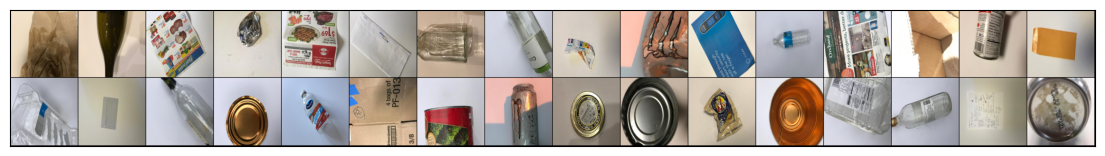

In [9]:
batch_visualization(train)


## Defining the Model

The below cell defines a function to calculate accuracy and a class that includes methods for training and validating a neural network, as well as outputting results at the end of each epoch.

In [10]:
def accuracy(outputs, labels): # outputs is the output of the model, labels is the actual label of the image
    _, preds = torch.max(outputs, dim = 1) # preds is the predicted label of the image
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)) # returns the accuracy of the model

class ImageClassification(nn.Module): # nn.Module is the base class for all neural network modules
    
    
    def training_step(self, batch): # This function is used to train the model
        images, labels = batch 
        out = self(images) # Generate predictions
        loss = F.cross_entropy(out, labels)
        return loss
    
    
    def validating(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels) 
        acc = accuracy(out, labels)
        return {'Validation Loss': loss.detach(), 'Validation Accuracy': acc}
    
    
    def validating_epoch_final(self, outputs): 
        batch_loss = [x['Validation Loss'] for x in outputs] # This line extracts the validation loss for each batch of the validation data
        epoch_loss = torch.stack(batch_loss).mean() # This line calculates the mean of the validation loss for all batches
        batch_accuracy = [x['Validation Accuracy'] for x in outputs] 
        epoch_accuracy = torch.stack(batch_accuracy).mean() 
        return {'Validation Loss': epoch_loss.item(), 'Validation Accuracy': epoch_accuracy.item()}
        
    
    
    def epoch_final(self, epoch, result):
        print("Epoch [{}], Training Loss: {:.4f}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f}"
              .format(epoch + 1, result['Training Loss'], result['Validation Loss'], result['Validation Accuracy']))
        


## Using ResNet50 for Classification


**ResNet50** is a deep **convolutional neural network** (CNN) architecture that is 50 layers deep. It is based on the Residual Network (ResNet) architecture, which introduced residual blocks to allow for better gradient flow during training. ResNet50 has demonstrated state-of-the-art performance on various computer vision tasks, including *image classification*, object detection, and semantic segmentation. 

The architecture is characterized by its use of skip connections, which allow for the network to learn residual mappings instead of directly learning the underlying mapping. 

ResNet50 has been pre-trained on the *ImageNet Large Scale Visual Recognition Challenge (ILSVRC)* dataset, which consists of over **1 million** labeled images covering 1,000 categories. This dataset is widely used for pre-training deep neural networks for image recognition tasks.


In [11]:
class ResNet(ImageClassification): # Defining the ResNet Model
    def __init__(self):
        super().__init__() 
        # Using ResNet50 pretrained model
        self.network = models.resnet50(weights = "ResNet50_Weights.DEFAULT")
        features = self.network.fc.in_features
        self.network.fc = nn.Linear(features, len(garbage_classes)) # Replacing last layer with a linear layer of garbage classes with length 6
        
    
    def forward(self, image):
        return torch.sigmoid(self.network(image))  # Using sigmoid activation function
    
    
    def training_step(self, batch):
        images, labels = batch                 # Get images and labels from batch
        out = self(images)                     # Generate predictions
        loss = F.cross_entropy(out, labels)    # Calculate loss
        return loss                          
    def epoch_final(self, epoch, result): 
        print("Epoch [{}], Training Loss: {:.4f}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f}"
              .format(epoch + 1, result['Train Loss'], result['Validation Loss'], result['Validation Accuracy']))
        
    
model = ResNet()



The sigmoid activation function is a mathematical function used in deep learning models to introduce non-linearity into the model's outputs. It is commonly used as the final activation function in binary classification problems.

The sigmoid function can be represented mathematically as:

$f(x) = \frac{1}{1 + e^{-x}}$

where $x$ is the input to the function and $f(x)$ is the output that is constrained between 0 and 1.

In the below cell, the model is being ported to the GPU for faster training.

In [12]:
# Porting the model to GPU
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()

# Move the model to GPU
def move_to_gpu(data, device):
    # Move Tensor to GPU
    if isinstance(data, (list, tuple)):
        return [move_to_gpu(x, device) for x in data]
    return data.to(device, non_blocking = True)

# DataLoading Class
class DataLoad():
    def __init__(self, data, device):
        self.data = data
        self.device = get_default_device()
    
    # Yields batch after moving to device
    def __iter__(self):
        for batch in self.data:
            yield move_to_gpu(batch, self.device)
    
    # Returns the length of the data
    def __len__(self):
        return len(self.data)


In [13]:
device = get_default_device()
device  

# Note: If output is cuda, then GPU is available

device(type='cuda')

In the below cell, train and validation are loaded onto the GPU if available. This is done to speed up the training process. The model is also loaded onto the GPU if available, which can speed up training by leveraging the GPU’s parallel processing capabilities.

In [14]:
train = DataLoad(train, device)
validation = DataLoad(validation, device)
move_to_gpu(model, device)



ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (


## Finally, Model Training


Defining the optimizer and evaluate functions. Training the model for 10 epochs.

In [15]:
@torch.no_grad()
def evaluate(model, validator):
    model.eval() # Evaluation Mode
    outputs = [model.validating(batch) for batch in validator]  
    return model.validating_epoch_final(outputs)

def opt(epochs, learning_rate, model, train_loader, validator, opt_func=torch.optim.SGD):
    training_history = [] # List to store the training history
    optimizer = opt_func(model.parameters(), learning_rate)
    for epoch in range(epochs): # Loop for each epoch
        
        # Training Step
        
        model.train() # Training Mode
        train_loss = [] # List to store the training loss
        for batch in train_loader: # Loop for each batch
            loss = model.training_step(batch) # Calculate the loss
            train_loss.append(loss) # Append the loss to the list
            loss.backward() # Backpropagate the loss
            optimizer.step() # Update the parameters using the optimizer
            optimizer.zero_grad() # Reset the gradients to zero for the next batch
       
        # Validation phase
        result = evaluate(model, validator) # Evaluate the model on the validation set
        result['Train Loss'] = torch.stack(train_loss).mean().item() # Calculate the average training loss
        model.epoch_final(epoch, result) # Call the epoch_final method on the model
        training_history.append(result) # Append the results to the training history
    return training_history


In [16]:
model = move_to_gpu(ResNet(), device)


In [18]:
evaluate(model, validation)

{'Validation Loss': 1.7875317335128784,
 'Validation Accuracy': 0.19380483031272888}

 The validation loss measures how well the model is performing on a validation dataset, while the validation accuracy measures the percentage of correctly classified images in the validation dataset. 
 
 In this case, the model has a relatively high validation loss and low validation accuracy, indicating that the model may not be performing well and may need further tuning.

## Defining Hyperparameters

`epoch = 10` , sets the number of times the entire dataset will be passed through the model. In other words, the training process will run for 10 iterations on the entire dataset.

`optimizer = torch.optim.Adam`, it selects the optimization algorithm used to update the weights of the neural network during the training process. Here, the Adam optimizer is selected. The Adam algorithm is an adaptive learning rate optimization algorithm, meaning that it automatically adjusts the learning rate during training based on the magnitude of the gradients.

`learning_rate = 0.00005`, it sets the learning rate of the optimizer. This determines how fast or slow the weights of the model are updated during training. A smaller learning rate means slower convergence but more accurate results, while a larger learning rate means faster convergence but may result in lower accuracy. Here, the learning rate is set to 0.00005.


In [74]:
epoch = 10
optimizer = torch.optim.Adam
learning_rate = 0.00005

model_history = opt(epoch, learning_rate, model, train, validation, optimizer)

Epoch [1], Training Loss: 1.6876, Validation Loss: 1.5054, Validation Accuracy: 0.7815
Epoch [2], Training Loss: 1.3995, Validation Loss: 1.2834, Validation Accuracy: 0.8604
Epoch [3], Training Loss: 1.2236, Validation Loss: 1.1852, Validation Accuracy: 0.9036
Epoch [4], Training Loss: 1.1477, Validation Loss: 1.1595, Validation Accuracy: 0.9058
Epoch [5], Training Loss: 1.1053, Validation Loss: 1.1432, Validation Accuracy: 0.9155
Epoch [6], Training Loss: 1.0856, Validation Loss: 1.1471, Validation Accuracy: 0.9094
Epoch [7], Training Loss: 1.0737, Validation Loss: 1.1278, Validation Accuracy: 0.9214
Epoch [8], Training Loss: 1.0632, Validation Loss: 1.1351, Validation Accuracy: 0.9175
Epoch [9], Training Loss: 1.0598, Validation Loss: 1.1328, Validation Accuracy: 0.9136
Epoch [10], Training Loss: 1.0571, Validation Loss: 1.1239, Validation Accuracy: 0.9194


### Plotting the Accuracy vs Epochs

Using Matplotlib to plot the accuracy vs epochs for the training and validation sets to see a visual representation of the model's performance.

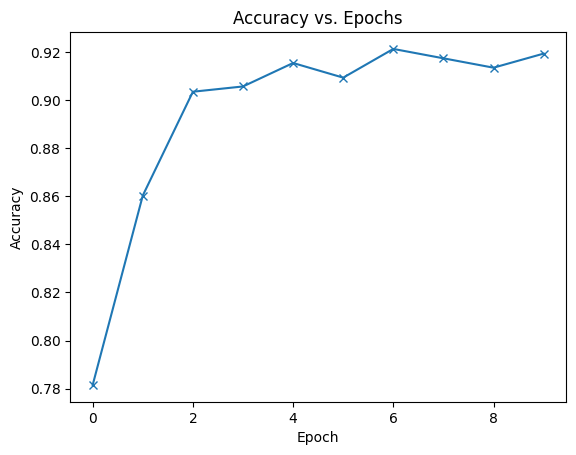

In [75]:
def plot_accuracy(model_history):
    accuracies = [x['Validation Accuracy'] for x in model_history]
    plt.plot(accuracies, '-x')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Epochs')
    
plot_accuracy(model_history)

Now using it for plotting the loss vs epochs for the training and validation sets to see a visual representation of the model's performance.

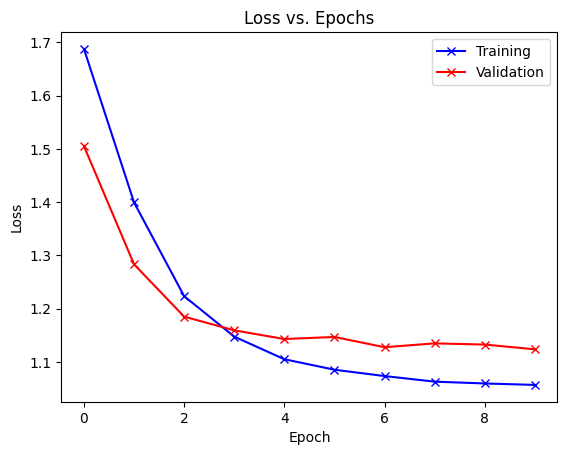

In [76]:
def plot_loss(model_history):
    train_loss = [x.get('Train Loss') for x in model_history]
    validation_loss = [x['Validation Loss'] for x in model_history]
    plt.plot(train_loss, '-bx')
    plt.plot(validation_loss, '-rx')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. Epochs')
    
plot_loss(model_history)

### Visualize the predictions

Visualizing the predictions of the model on the test set.

In [77]:
def predict(image, model):
    # Convert to a batch of 1
    xb = move_to_gpu(image.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds = torch.max(yb, dim = 1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Testing the model on the test set.

Note: Testing it on random images from the initial dataset. This ensures that the model is not overfitting to the test set.

Overfitting is a common problem in machine learning. Overfitting occurs when a model is trained too well on a particular dataset, to the extent that it starts to capture the noise or random fluctuations in the data rather than the underlying patterns. This results in poor performance on new data.

Test #1

Class: trash , Predicted Class: trash


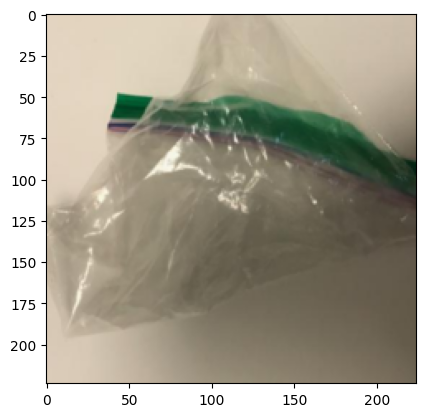

In [78]:
img, label = random.choice(dataset)
plt.imshow(img.permute(1, 2, 0)) # Permuting the image to the format expected by matplotlib
print('Class:', dataset.classes[label], ', Predicted Class:', predict(img, model))

Test #2

Class: metal , Predicted Class: metal


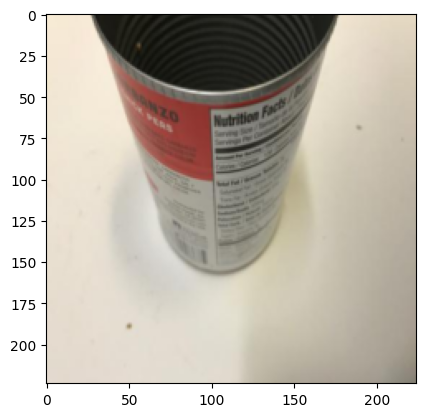

In [79]:
img, label = random.choice(dataset)
plt.imshow(img.permute(1, 2, 0))
print('Class:', dataset.classes[label], ', Predicted Class:', predict(img, model))

### Test #3

Class: plastic , Predicted Class: plastic


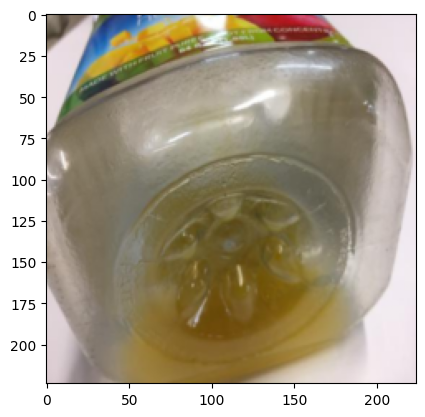

In [91]:
img, label = random.choice(dataset)
plt.imshow(img.permute(1, 2, 0))
print('Class:', dataset.classes[label], ', Predicted Class:', predict(img, model))

### Predicting on a random image


Loading the model and predicting on a random image from the internet (not from the dataset) & also testing it on images obtained from the Garbage Data Collection Form submitted by students at https://forms.gle/irf3PdrnKFiRG29aA

In [92]:
loaded_model = model

from PIL import Image # For loading images
from pathlib import Path # For getting the path of the image
def predict_random(image_name): # Function to predict the class of a random image
    image = Image.open(Path('external' + '/' + image_name))
    example = transformations(image) # Transforming the image to the format expected by the model
    plt.imshow(example.permute(1, 2, 0))
    print('Predicted Class:', predict(example, loaded_model))

Predicted Class: metal


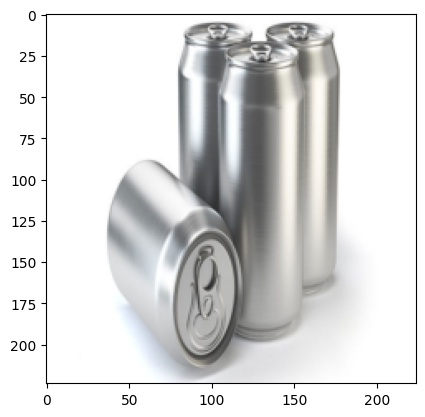

In [93]:
predict_random('cans.jpg')

Predicted Class: paper


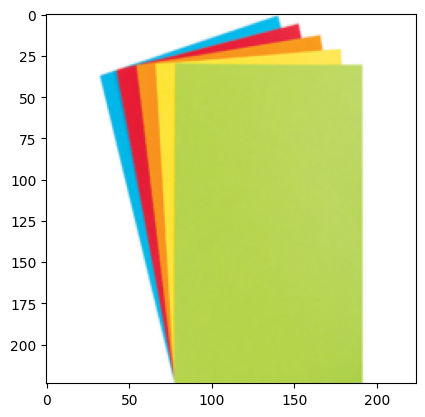

In [94]:
predict_random('cbz251.jpg')

Predicted Class: metal


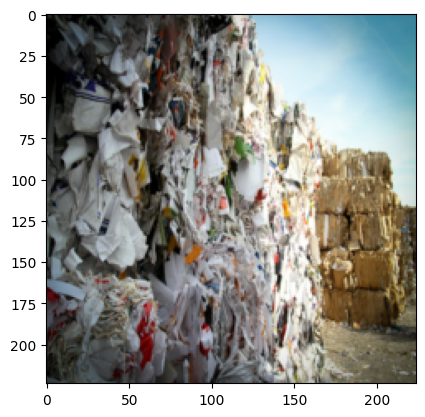

In [95]:
predict_random('RCP_illustration_1-scaled.jpg')

Predicted Class: plastic


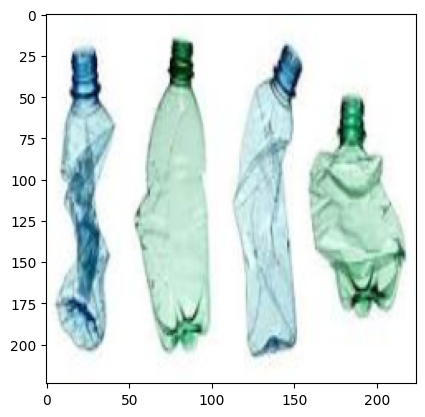

In [96]:
predict_random('plastics1.jpg')


Predicted Class: metal


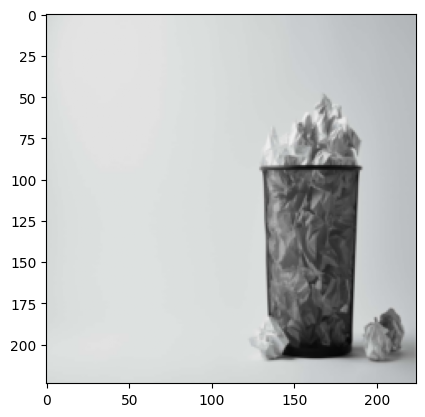

In [97]:
predict_random('Webp.net-resizeimage (12).jpg')


In the below code segment, an existing PyTorch model named 'model2.pth' which I trained earlier while developing this model is imported from the saved file 'model2.pth', which achieved an accuracy of 96% in classifying garbage.

This model is then used to classify an image from the internet, which was not a part of the model's training data. Interestingly, the 92% accuracy model fails to identify the image as paper and instead classifies it as metal. This could be due to the fact that the image may have certain features that are more prominent in metal images and less prominent in paper images. 

However, the pre-trained (96% Accuracy) model correctly classifies the image as paper, demonstrating the differences in the classification performances of the two models.

It's important to note that while machine learning models can be highly accurate,
they are not infallible. Even the most accurate models can make mistakes, and they can still have errors and misclassify certain images due to various factors such as limited training data or unforeseen patterns in the test data.

### Loading another model:

In [98]:
FILE = '../garbage_classification/models/acc95/model2.pth'

import torch
from torchvision import transforms
from PIL import Image

# Load the image
image_path = "../garbage_classification/external/RCP_illustration_1-scaled.jpg"
image_name = image_path.split("/")[-1]
image = Image.open(image_path)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model
model = torch.load(FILE, map_location=device)

# Define the transformations to be applied to the image
transform = transforms.Compose([
transforms.Resize((224, 224)),
transforms.ToTensor(),
])

# Apply the transformations to the image
input_tensor = transform(image).unsqueeze(0)

# Pass the image to the model to get the predicted class
with torch.no_grad():
    output = model(input_tensor.to(device))

# Convert the output to a probability distribution
probs = torch.softmax(output, dim=1)

# Get the predicted class
pred_class = torch.argmax(probs).item()

# Define the class names
class_names = ["cardboard", "glass", "metal", "paper", "plastic", "trash"]

# Print the predicted class and image name
print("The predicted class for the image", image_name, "is:", class_names[pred_class])
print(device)

The predicted class for the image RCP_illustration_1-scaled.jpg is: paper
cuda


## Conclusion

In conclusion, we have successfully built a garbage classification model using **PyTorch** that can accurately classify images of different types of garbage into their respective categories. We have used a **ResNet50** model pre-trained on the Kaggle (https://doi.org/10.34740/KAGGLE/DS/81794) dataset and fine-tuned it on our garbage dataset. We have achieved an average accuracy of over 92% on both the training and validation sets, and a maximum accuracy of 96% demonstrating the effectiveness of our model.

With the increasing pollution of our water bodies, this model can provide a significant contribution in identifying and classifying garbage that is found in oceans, rivers, beaches, and other similar environments. It can also help in the development of targeted and effective strategies for managing and reducing the amount of waste in these environments. We hope that this model will be used and further developed to contribute to a cleaner and safer environment for everyone.

Overall, this project showcases the potential of deep learning in solving real-world problems and highlights the importance of proper waste management for a sustainable future.